In [2]:
import backtrader as bt
import datetime as datetime
from backtrader_plotting import Bokeh

In [3]:
# 创建策略继承bt.Strategy
class TestStrategy(bt.Strategy):
    params = (
        # 持仓够5个单位就卖出
        ('exitbars', 5),
        ('maperiod', 10),
    )

    def log(self, txt, dt=None, printLog=False):
        # 记录策略的执行日志
        dt = dt or self.datas[0].datetime.date(0)
        if printLog:
            print('%s, %s \n' % (dt.isoformat(), txt))

    def stop(self):
        self.log("(均线周期 %d)期末资金 %.2f" %
                 (self.params.maperiod, self.broker.getvalue()), printLog=True)

    def __init__(self):
        # 保存收盘价的引用
        self.dataclose = self.datas[0].close
        self.sma = bt.indicators.MovingAverageSimple(
            self.datas[0], period=self.params.maperiod)
#         bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
#         bt.indicators.WeightedMovingAverage(self.datas[0], period=25).subplot = True
#         self.rsi = bt.indicators.RSI(self.sma)
#         bt.indicators.SmoothedMovingAverage(self.rsi, period=10)
#         bt.indicators.ATR(self.datas[0]).plot = False
#         bt.indicators.StochasticSlow(self.datas[0])
#         self.macd=bt.indicators.MACDHisto(self.datas[0])

        # 跟踪挂单
        self.order = None
        # 买入价格和手续费
        self.buyprice = None
        self.buycomm = None

    # 交易状态通知，一买一卖算交易

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('交易利润, 毛利润 %.2f, 净利润 %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # broker 提交/接受了，买/卖订单则什么都不做
            return

        # 检查一个订单是否完成
        # 注意: 当资金不足时，broker会拒绝订单
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    '已买入, 价格: %.2f, 费用: %.2f, 佣金 %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm

            elif order.issell():
                self.log('已卖出, 价格: %.2f, 费用: %.2f, 佣金 %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                self.log('已卖出, 数量: %s' %
                         (order.executed.size))

            # 记录当前交易数量
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('订单取消/保证金不足/拒绝')

        # 其他状态记录为：无挂起订单
        self.order = None

    def next(self):
        # 记录收盘价
        self.log('Close, %.2f' % self.dataclose[0])

        # 如果有订单正在挂起，不操作
        if self.order:
            return

        # 如果没有持仓则买入
        if not self.position:
            # 今天的收盘价 < 昨天收盘价
            if self.dataclose[0] > self.sma[0]:
                # 昨天收盘价 < 前天的收盘价
                # 买入
                self.log('买入, %.2f' % self.dataclose[0])
                # 跟踪订单避免重复
                self.order = self.buy()
        else:
            # 如果已经持仓，且当前交易数据量在买入后5个单位后
            if self.dataclose[0] < self.sma[0]:
                # 全部卖出
                self.log('卖出, %.2f' % self.dataclose[0])
                # 跟踪订单避免重复
                self.order = self.sell()

In [7]:
    # 创建交易数据集
data = bt.feeds.YahooFinanceCSVData(
    dataname="orcl-1995-2014-1.csv",
    # 数据必须大于fromdate
    fromdate=datetime.datetime(2000, 1, 1),
    # 数据必须小于todate
    todate=datetime.datetime(2002, 12, 31),
    reverse=False)


In [5]:
import pandas as pd
dataframe = pd.read_csv('dfqc.csv', index_col=0, parse_dates=True)
dataframe['openinterest'] = 0
data = bt.feeds.PandasData(dataname=dataframe,
                        fromdate = datetime.datetime(2015, 1, 1),
                        todate = datetime.datetime(2016, 12, 31)
                        )

Starting Portfolio Value: 10000.00
2002-12-30, (均线周期 10)期末资金 9742.90 

Final Portfolio Value: 9742.90
SR: OrderedDict([('sharperatio', -7.906229499966973)])
DW: AutoOrderedDict([('len', 692), ('drawdown', 3.8051795464194167), ('moneydown', 385.3999999999978), ('max', AutoOrderedDict([('len', 692), ('drawdown', 3.8417108497970704), ('moneydown', 389.0999999999967)]))])


开始日期,2000-01-03
结束日期,2002-12-30
所有月份,35
,Backtest
年度收益,-0.87%
累计收益,-2.571%
年度波动率,1.084%
夏普比率,-0.80
卡玛比率(夏普比率的改进),-0.23
稳定性,0.92
最大回撤,-3.842%


最严重回撤时期,Net drawdown in %,高峰日期,底部日期,反弹日期,Duration
0,3.84,2000-03-27,2002-10-07,NaT,NaN
1,0.33,2000-03-09,2000-03-14,2000-03-15,5
2,0.30,2000-01-21,2000-01-26,2000-02-10,15
3,0.27,2000-02-29,2000-03-02,2000-03-03,4
4,0.21,2000-02-10,2000-02-24,2000-02-25,12


应激事件,mean,min,max
Dotcom,-0.01%,-0.24%,0.33%
9/11,0.01%,-0.04%,0.10%


历史上排名前 10 位的多头头寸,max
orcl-1995-2014-1,4.36%


历史上排名前 10 的空头头寸,max


历史上排名前 10 的仓位,max
orcl-1995-2014-1,4.36%


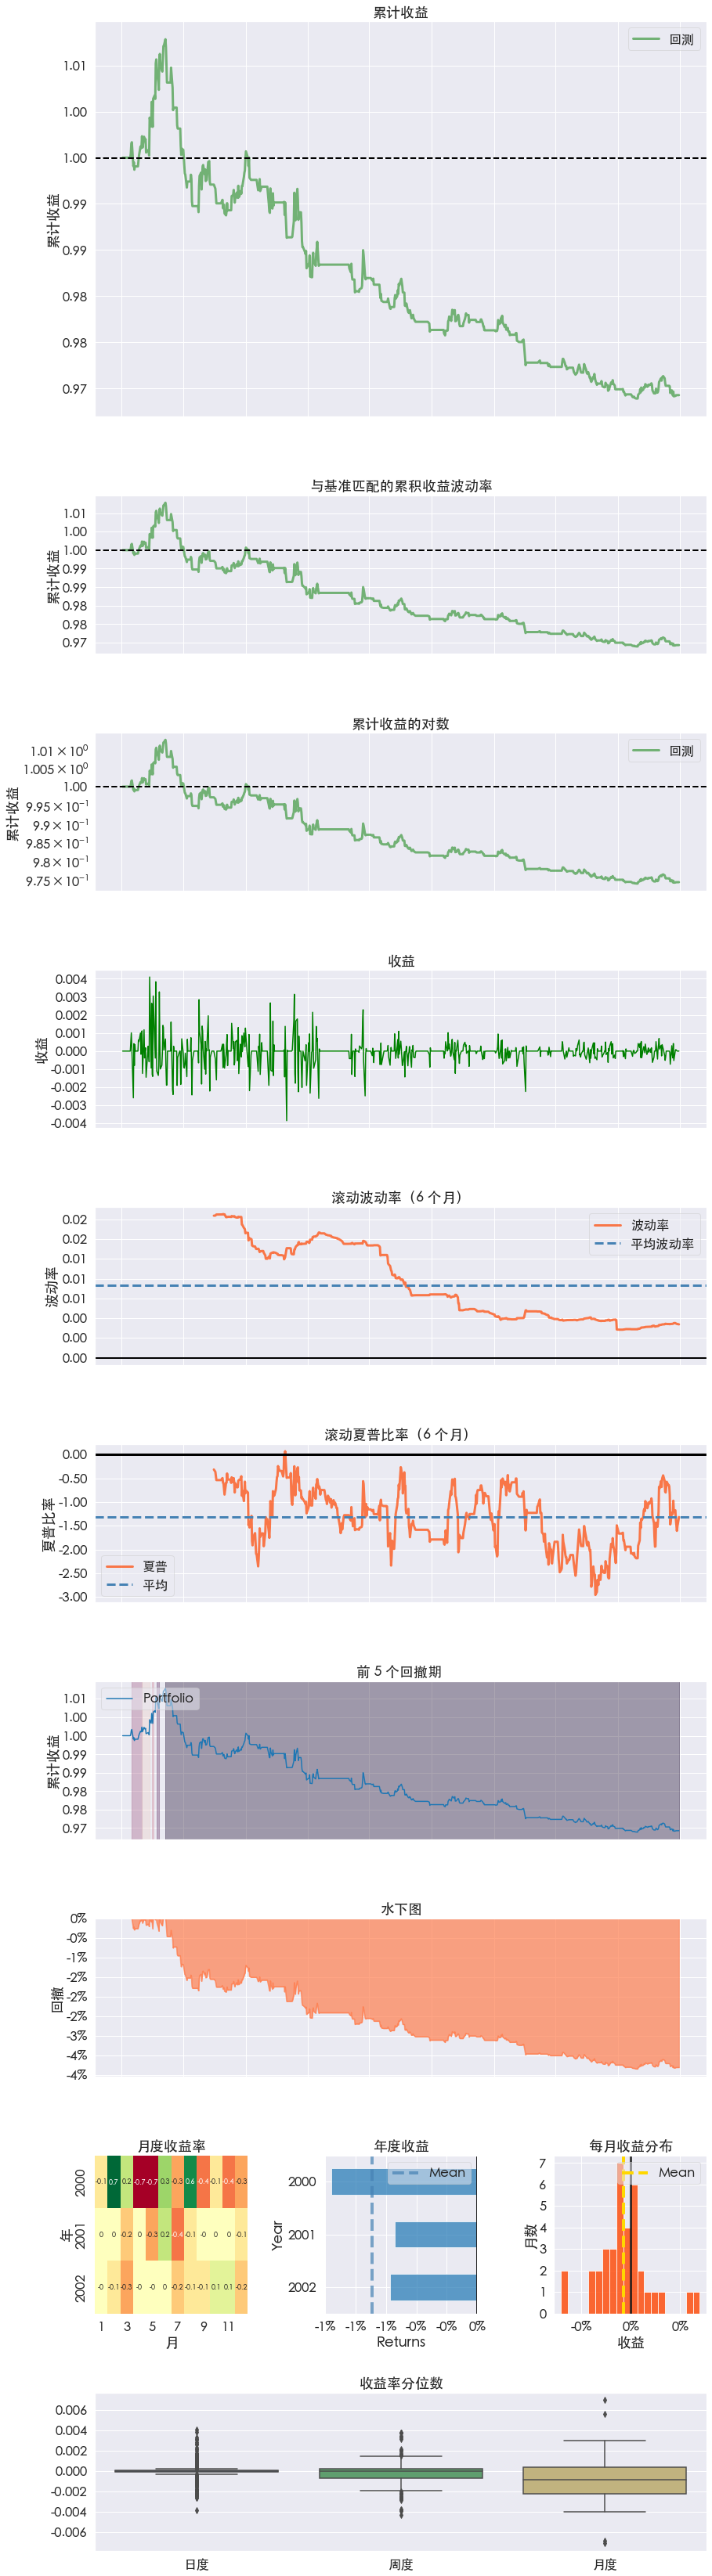

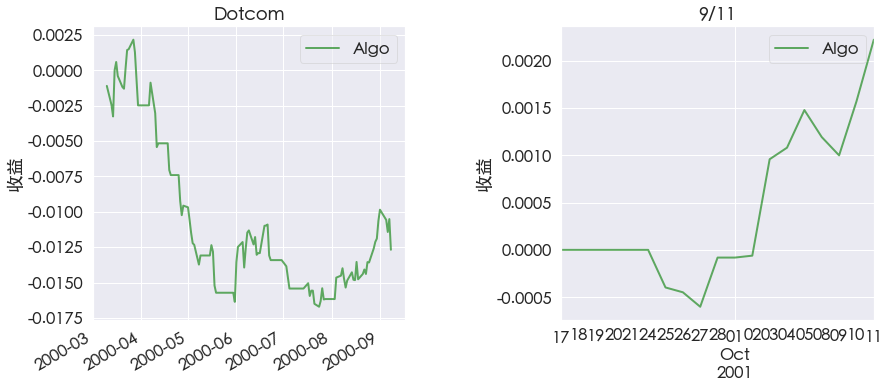

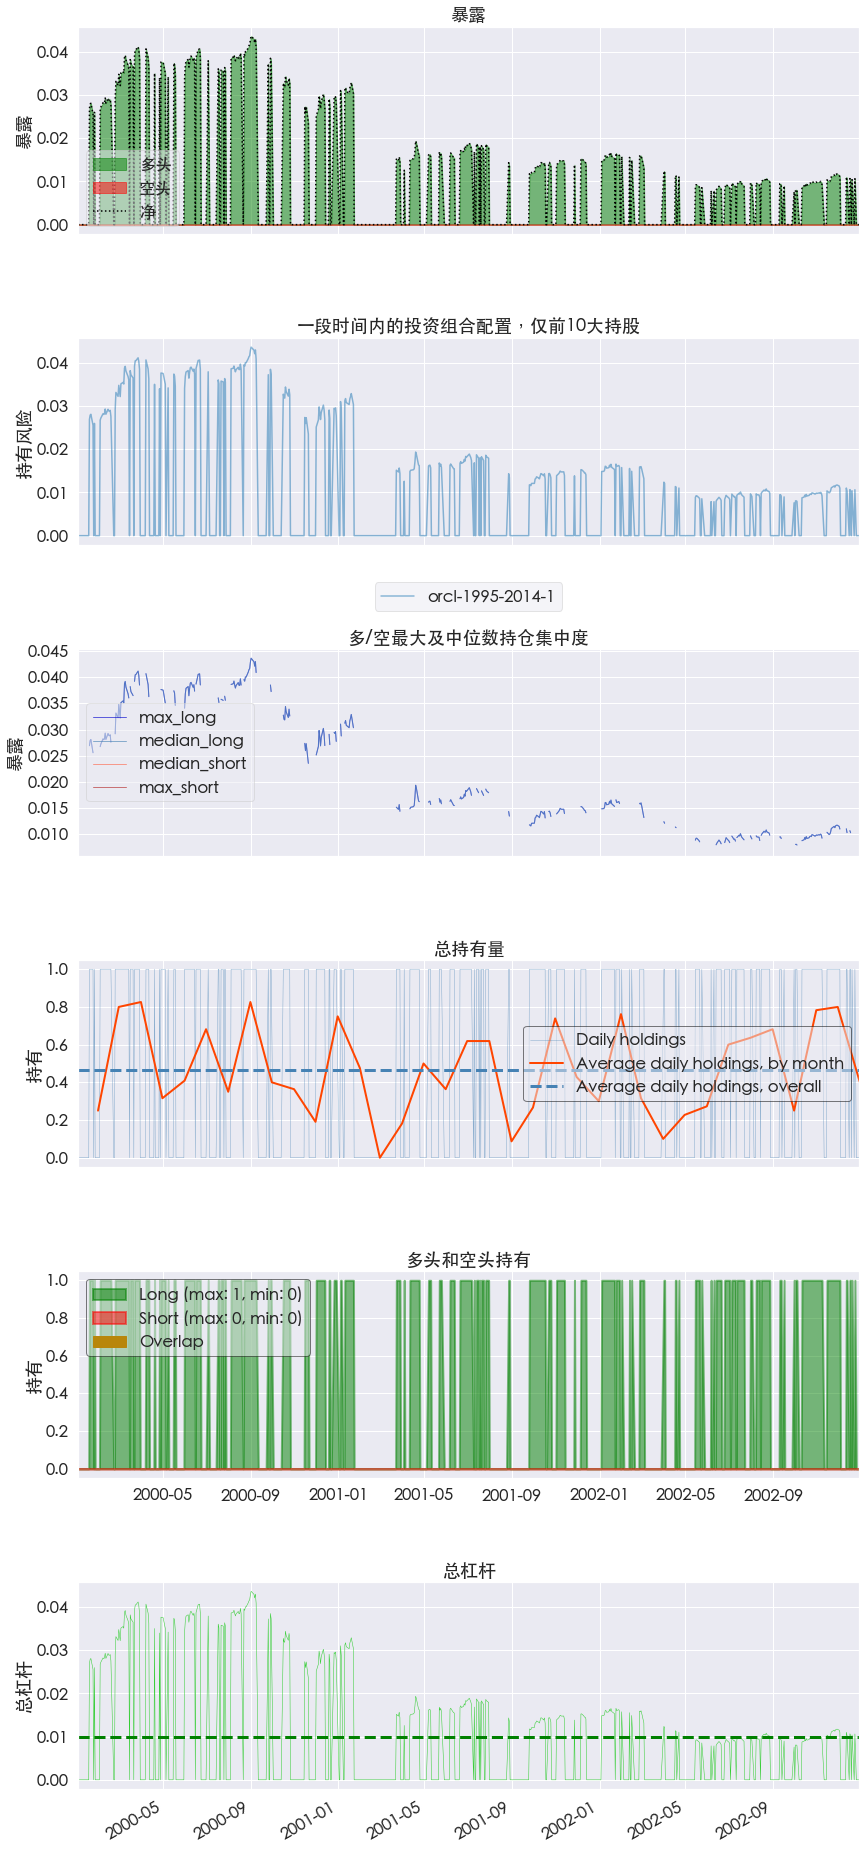

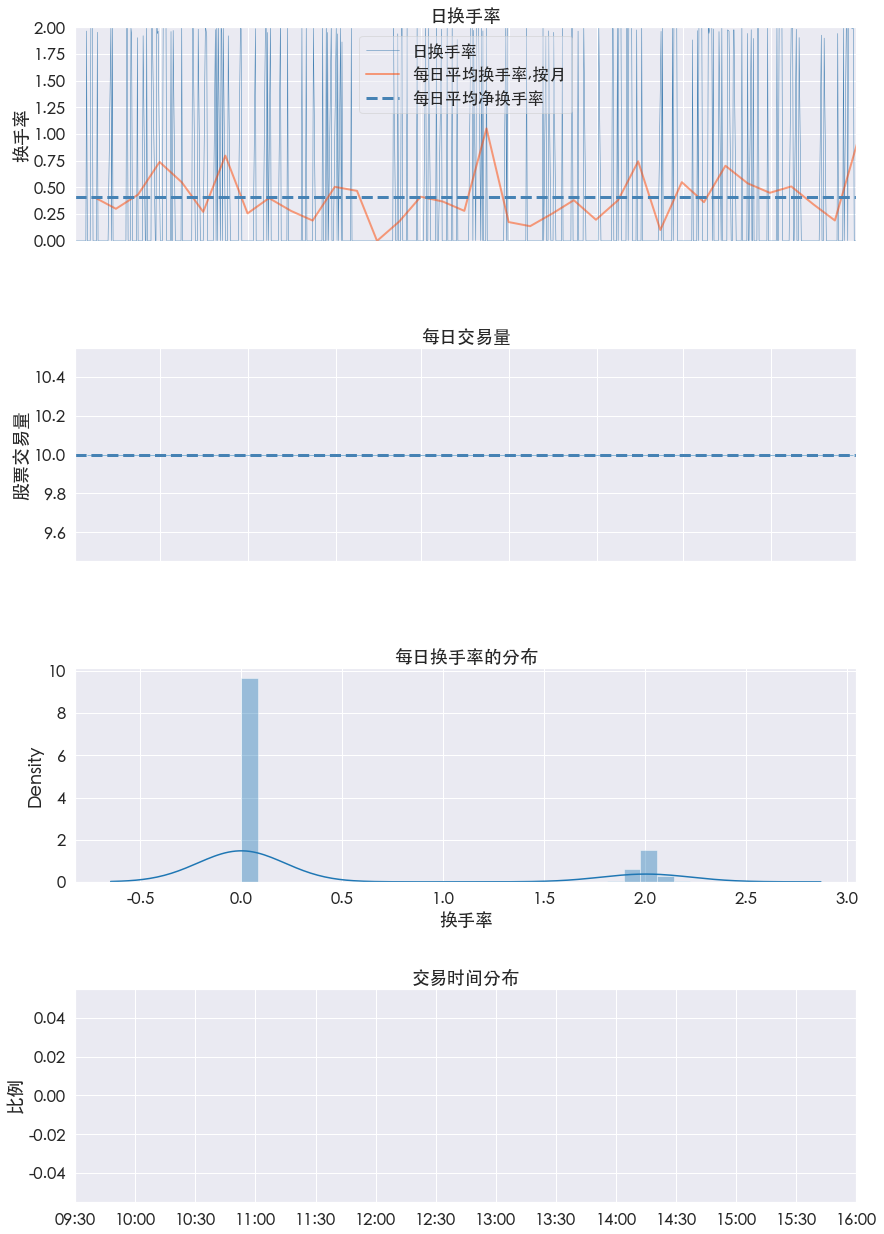

In [8]:
import pandas as pd
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.broker.setcommission(commission=0.0)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

results = cerebro.run()
strat = results[0]
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('SR:', strat.analyzers.SharpeRatio.get_analysis())
print('DW:', strat.analyzers.DW.get_analysis())
pyfoliozer = strat.analyzers.getbyname('pyfolio')
import pyfolio as pf
import warnings
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['Heiti TC'] #显示中文标签

warnings.filterwarnings("ignore")
%matplotlib inline
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    )

# cerebro.plot()

# from backtrader_plotting.schemes import Tradimo
# from backtrader_plotting.bokeh.optbrowser import OptBrowser
# b = Bokeh(style='bar')
# b = Bokeh(style='bar', scheme=Tradimo())
# cerebro.plot(b)